In [1]:
!wget -nc https://combineresearch.com/datasets/airline_passengers.csv

--2022-08-12 18:08:39--  https://combineresearch.com/datasets/airline_passengers.csv
Resolving combineresearch.com (combineresearch.com)... 62.221.254.104
Connecting to combineresearch.com (combineresearch.com)|62.221.254.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2036 (2.0K) [text/csv]
Saving to: ‘airline_passengers.csv’

airline_passengers. 100%[===================>]   1.99K  --.-KB/s    in 0s      

2022-08-12 18:08:40 (211 MB/s) - ‘airline_passengers.csv’ saved [2036/2036]



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)

In [4]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


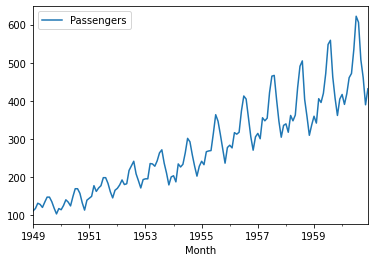

In [5]:
df.plot();

In [6]:
df['1stdiff'] = df['Passengers'].diff()

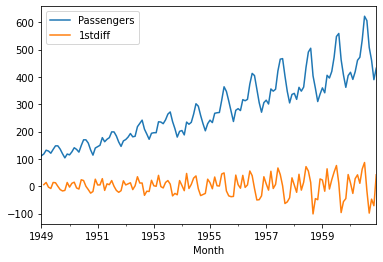

In [7]:
df.plot();

In [8]:
df['LogPassengers'] = np.log(df['Passengers'])

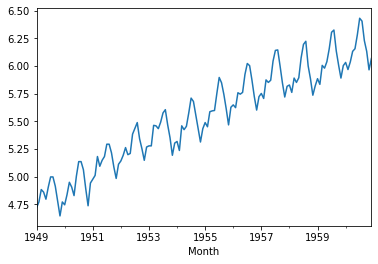

In [10]:
df['LogPassengers'].plot();

In [11]:
from statsmodels.tsa.arima_model import ARIMA

In [12]:
# MS = months
df.index.freq = 'MS'

Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [13]:
arima = ARIMA(train['Passengers'], order=(1,0,0))

In [14]:
arima_result = arima.fit()

In [15]:
df.loc[:-Ntest, 'AR(1)'] = arima_result.predict(start=train.index[0], end=train.index[-1])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)


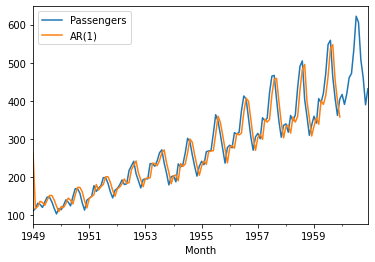

In [16]:
df[['Passengers', 'AR(1)']].plot();

In [18]:
forecast, stderr, confint = arima_result.forecast(Ntest)
df.loc[-Ntest:, 'AR(1)'] = forecast

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)


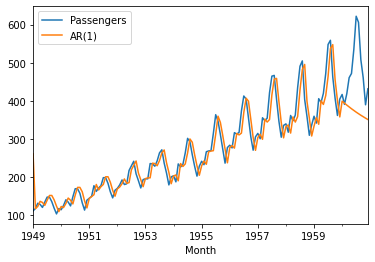

In [19]:
df[['Passengers', 'AR(1)']].plot();

In [20]:
def plot_fit_and_forecast(result):
  fig, ax = plt.subplots(figsize=(10,5))
  ax.plot(df['Passengers'], label='data')

  # plot the curve fitted on train set
  train_pred = result.fittedvalues
  ax.plot(train.index, train_pred, color='green', label='fitted')

  # forecast the test set
  forecast, stderr, confint = result.forecast(Ntest)
  ax.plot(test.index, forecast, label='forecast')
  ax.fill_between(test.index, \
                  confint[:,0], confint[:,1], \
                  color='red', alpha=0.3)
  ax.legend()

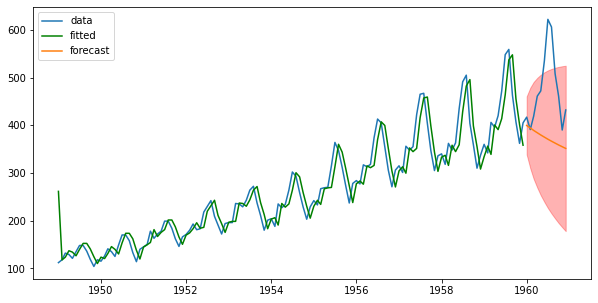

In [21]:
plot_fit_and_forecast(arima_result)

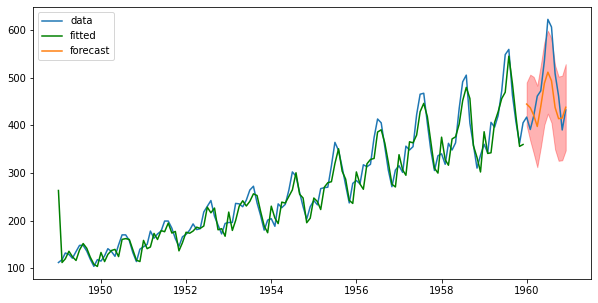

In [22]:
arima = ARIMA(train['Passengers'], order=(10,0,0)) #AR(10)
arima_result = arima.fit()
plot_fit_and_forecast(arima_result)

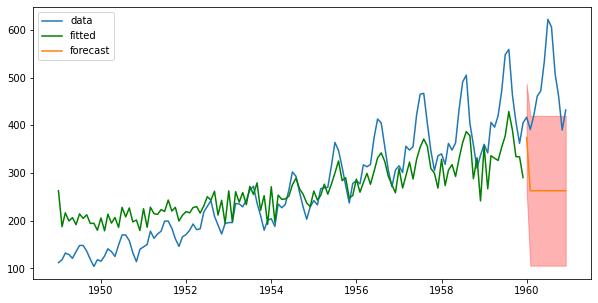

In [24]:
arima = ARIMA(train['Passengers'], order=(0,0,1)) #MA(1)
arima_result = arima.fit()
plot_fit_and_forecast(arima_result)

In [25]:
df['Log1stDiff'] = df['LogPassengers'].diff()

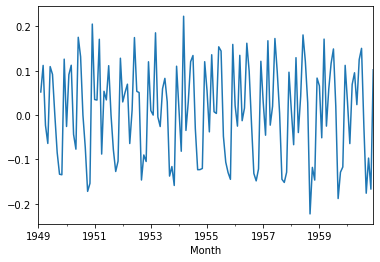

In [26]:
df['Log1stDiff'].plot();

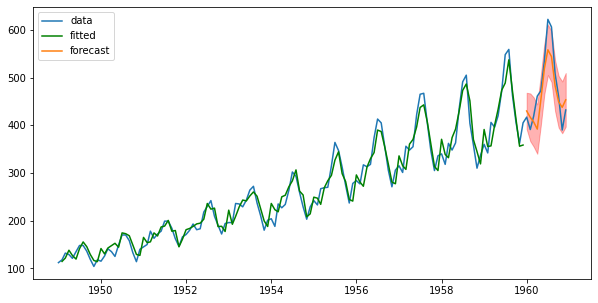

In [27]:
arima = ARIMA(train['Passengers'], order=(8,1,1)) # p=8,d=1,q=1
arima_result_811 = arima.fit()

def plot_fit_and_forecast_int(result, d, col='Passengers'):
  fig, ax = plt.subplots(figsize=(10,5))
  ax.plot(df[col], label='data')

  # plot the curve fitted on train set
  train_pred = result.predict(start=train.index[d], end=train.index[-1], \
                              typ='levels')
  
  ax.plot(train.index[d:], train_pred, color='green', label='fitted')

  # forecast the test set
  forecast, stderr, confint = result.forecast(Ntest)
  ax.plot(test.index, forecast, label='forecast')
  ax.fill_between(test.index, \
                  confint[:,0], confint[:,1], \
                  color='red', alpha=0.3)
  ax.legend()

plot_fit_and_forecast_int(arima_result_811, 1)

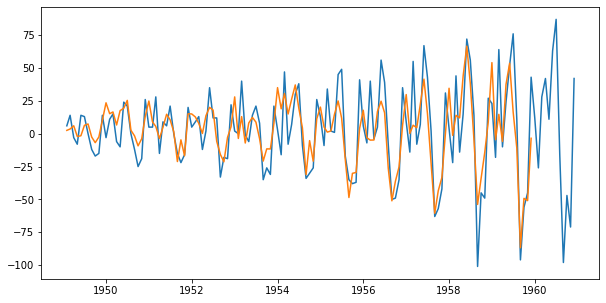

In [28]:
def plot_difference(result, d, col='Passengers'):
  train_pred = result.predict(start=train.index[d], end=train.index[-1])
  #train_pred = result.fittedvalues
  diff = df[col].diff()
  fig, ax = plt.subplots(figsize=(10, 5))
  ax.plot(diff, label='true 1st difference')
  ax.plot(train_pred, label='fitted 1st difference');

plot_difference(arima_result_811, 1)

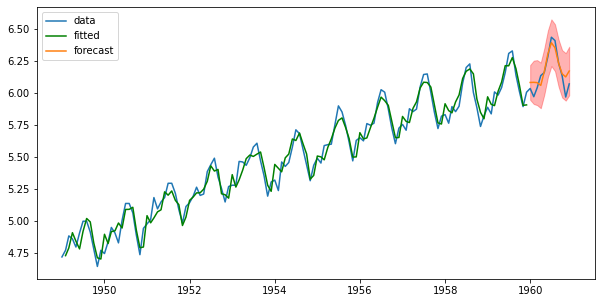

In [29]:
arima = ARIMA(train['LogPassengers'], order=(8,1,1))
arima_result_log811 = arima.fit()
plot_fit_and_forecast_int(arima_result_log811, 1, col='LogPassengers')

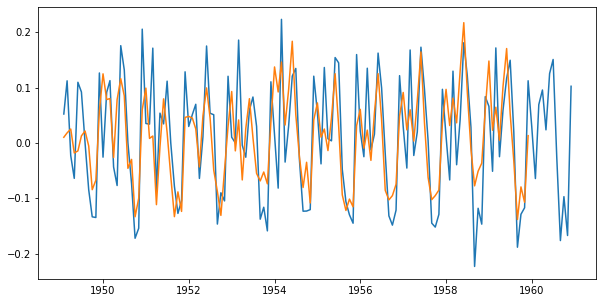

In [30]:
plot_difference(arima_result_log811, 1, col='LogPassengers')

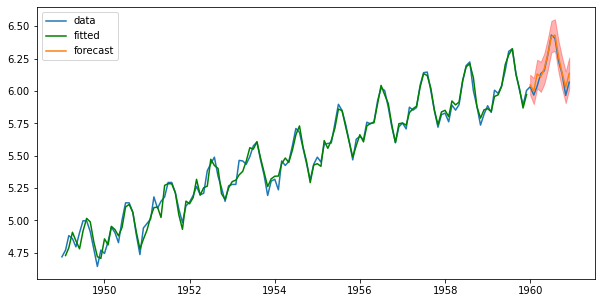

In [31]:
arima = ARIMA(train['LogPassengers'], order=(12,1,0))
arima_result_log1210 = arima.fit()
plot_fit_and_forecast_int(arima_result_log1210, 1, col='LogPassengers')

In [32]:
def rmse(result, is_logged):
  forecast, stderr, confint = result.forecast(Ntest)
  if is_logged:
    forecast = np.exp(forecast)

  t = test['Passengers']
  y = forecast
  return np.sqrt(np.mean((t - y)**2))

In [33]:
print("ARIMA(8,1,1):", rmse(arima_result_811, False))
print("ARIMA(8,1,1) logged:", rmse(arima_result_log811, True))
print("ARIMA(12,1,0) logged:", rmse(arima_result_log1210, True))

ARIMA(8,1,1): 38.550729237539144
ARIMA(8,1,1) logged: 32.224046261108924
ARIMA(12,1,0) logged: 18.61202109863076
